# Import packages

In [1]:
####import packages
using FFTW
using Distributions
using PyCall
using PyPlot
using Pkg
using Interpolations
using LinearAlgebra
using Profile
using TensorOperations
import NaNMath
using DelimitedFiles

#get to the root of the project to ease path later on
if pwd()[end-7:end] == "Analysis"
    cd("..")
end

###import local files (CAUTION: kernel must be restarted if changes are made)
include("src/Coupling.jl") 
include("src/Phase.jl") 
include("src/PhaseSim.jl") 
include("src/Plots.jl") 


#@nbinclude("Types.ipynb")

###set nice plotting style
@pyimport matplotlib.pyplot as p
p.style[:use]("seaborn-whitegrid")

# Set global parameters

In [2]:
res_phase = 100 #must be even
domain_phase = range(0, stop=2*π, length=res_phase+1)[1:end-1]
dt = 0.5

###if debug plot must be made
DEBUG = false

false

# Create waveforms, coupling and noise

## Waveforms

### Generate a dictionnary of waveforms

In [3]:
#create dictionnary
d_waveforms = Dict()
#basic cos signal
d_waveforms["cos"] =  cos.(domain_phase)
#triangular signal
d_waveforms["triangle"] =  [x<=π ? 2*x/π-1 : 2*(2-x/π)-1 for (i,x) in enumerate(domain_phase)]
#complex signal 1
#d_waveforms["complex1"] =  2*cos.(domain_phase)/(-pi).+ 2*cos.(2*domain_phase)/(2*pi)
#complex signal 2
#d_waveforms["complex2"] =  2*sin.(domain_phase)/(-pi) .+ 2*sin.(2*domain_phase)/(2*pi) .+ 2*sin.(3*domain_phase)/(-3*pi) .+ 2*sin.(4*domain_phase)/(4*pi) 

100-element Array{Float64,1}:
 -1.0               
 -0.96              
 -0.92              
 -0.88              
 -0.84              
 -0.8               
 -0.76              
 -0.72              
 -0.6799999999999999
 -0.64              
 -0.6               
 -0.56              
 -0.52              
  ⋮                 
 -0.52              
 -0.56              
 -0.6000000000000001
 -0.6399999999999997
 -0.6800000000000002
 -0.7199999999999998
 -0.7600000000000002
 -0.7999999999999998
 -0.8399999999999999
 -0.8799999999999999
 -0.9199999999999999
 -0.9600000000000004

### Plot the waveforms

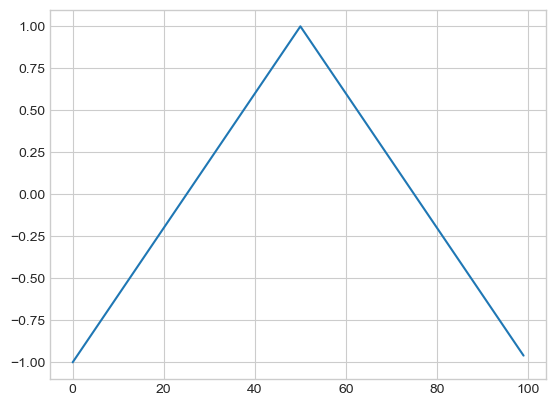

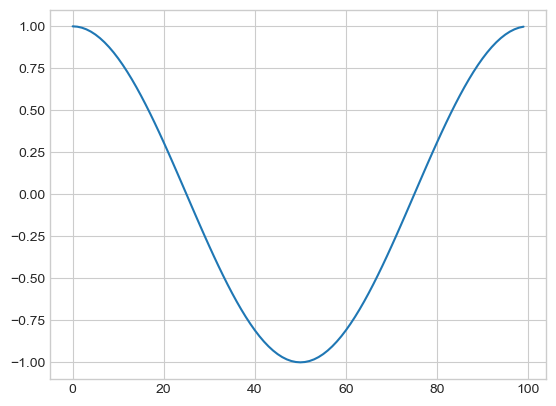

In [4]:
for (name_w, w) in d_waveforms
    figure()
    plot(w)
    savefig("Plots/Waveforms/"*name_w*".pdf")
    show()
end

## Couplings

### Generate a dictionnary of possible couplings

In [5]:
#create dictionnary
d_couplings = Dict()

#blank coupling
t_coor_1 = [0.,0.]
mat_var_1 = [0.5 0  
             0 0.5] 
l_amp = [0,0]
F_θ = build_F_from_2D_gaussian([t_coor_1], [mat_var_1,], l_amp, domain_phase)
d_couplings["blank"] =  F_θ

#coupling with two random gaussians
t_coor_1 = [1.5,4.5]
mat_var_1 = [0.5 0  
             0 0.5] 
t_coor_2 = [5,2]
mat_var_2 =  [0.5 0  
             0 0.5] 
l_amp = [-1,1]
#l_amp = [0,0]

F_θ = build_F_from_2D_gaussian([t_coor_1, t_coor_2], [mat_var_1, mat_var_2], l_amp, domain_phase)
d_couplings["2gaussians"] =  F_θ

#coupling with three random gaussians
t_coor_1 = [0.5,5.5]
mat_var_1 = [0.5 0 
            0 0.5]
t_coor_2 = [3, 2]
mat_var_2 =[0.5 0 
            0 0.5]  
t_coor_3 = [0, 3]
mat_var_3 = [0.5 0 
             0. 0.5]
l_amp = [-1,1, -1]
#l_amp = [0,0, 0]
F_ϕ = build_F_from_2D_gaussian([t_coor_1, t_coor_2, t_coor_3], [mat_var_1, mat_var_2, mat_var_3], l_amp, domain_phase)

d_couplings["3gaussians"] =  F_ϕ

100×100 Array{Float64,2}:
 -3.85631e-5  -5.61226e-5  -8.10141e-5  …  -0.174089   -0.160918   -0.147579 
 -3.8083e-5   -5.54813e-5  -8.0161e-5      -0.184645   -0.170676   -0.156527 
 -3.71618e-5  -5.42226e-5  -7.84479e-5     -0.194302   -0.179601   -0.164713 
 -3.57597e-5  -5.22973e-5  -7.5815e-5      -0.202855   -0.187508   -0.171963 
 -3.38267e-5  -4.96445e-5  -7.21891e-5     -0.21012    -0.194222   -0.17812  
 -3.12975e-5  -4.61848e-5  -6.7475e-5   …  -0.215933   -0.199595   -0.183047 
 -2.80851e-5  -4.18115e-5  -6.15447e-5     -0.220161   -0.203503   -0.186631 
 -2.40732e-5  -3.63812e-5  -5.42238e-5     -0.222707   -0.205856   -0.188787 
 -1.9107e-5   -2.97019e-5  -4.52773e-5     -0.223511   -0.206598   -0.189467 
 -1.29835e-5  -2.15201e-5  -3.43923e-5     -0.222552   -0.205711   -0.188652 
 -5.44048e-6  -1.15065e-5  -2.11596e-5  …  -0.219854   -0.203217   -0.186363 
  3.85532e-6   7.59449e-7  -5.0543e-6      -0.21548    -0.199172   -0.182652 
  1.53203e-5   1.58049e-5   1.45849e-5

### Plot the couplings

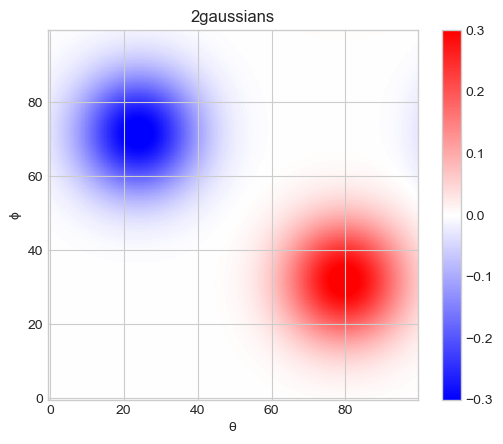

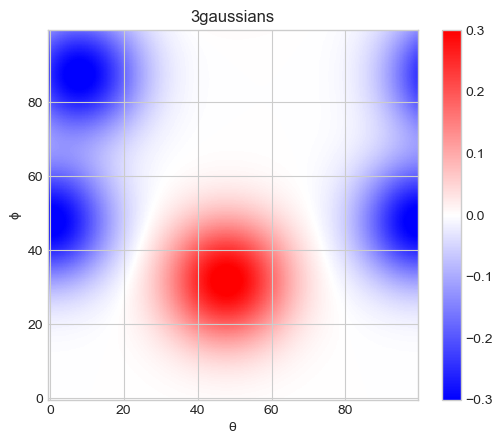

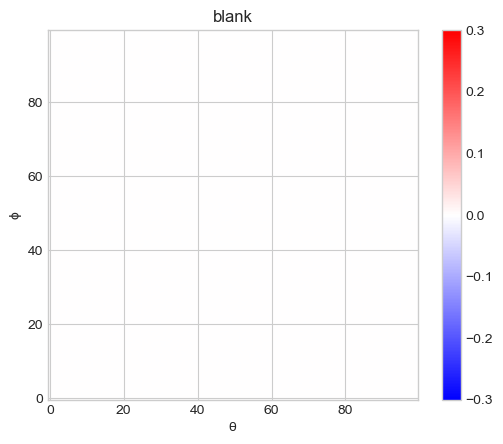

In [6]:
for (name_F, F) in d_couplings
    plot_F(F, title_fig = name_F, save = true)
end

## Generate a list of values of intrinsic and external noise

In [7]:
#main process
l_sigma = [0, 0.1]
l_epsilon = [0, 0.1]
#l_sigma = [0., 0.1, 0.25, 0.5, 1]
#l_epsilon = [0., 0.1, 0.25, 0.5, 1]

#amplitude and background
l_mu_A_theta = [1.]
l_gamma_A_theta = [0.1]
l_sigma_A_theta = [0, 0.1]

l_mu_B_theta = [0.]
l_gamma_B_theta = [0.1]
l_sigma_B_theta = [0, 0.1]

l_mu_A_phi = [1.]
l_gamma_A_phi = [0.1]
l_sigma_A_phi = [0, 0.1]

l_mu_B_phi = [0.]
l_gamma_B_phi = [0.1]
l_sigma_B_phi = [0, 0.1]


2-element Array{Float64,1}:
 0.0
 0.1

# Combine waveforms coupling and noise to build a dictionnary of coupled variables

In [8]:
d_var = Dict()

Dict{Any,Any} with 0 entries

## Consider several different scenarios

### two cos signals, no noise and no coupling

In [9]:
name_ω_θ = "cos"
name_ω_ϕ = "cos"
name_F_θ = "blank"
name_F_ϕ = "blank"
σ_ϕ1 = 0.
σ_ϕ2 = 0.
σₑ1 = 0.
σₑ2 = 0.
μₐ1 = 1.
γₐ1 = 0.1
σₐ1 = 0.
μᵦ1 = 0.
γᵦ1 = 0.1
σᵦ1 = 0.
μₐ2 = 1.
γₐ2 = 0.1
σₐ2 = 0.
μᵦ2 = 0.
γᵦ2 = 0.1
σᵦ2 = 0.

#first signal
FT_ω_θ = fft(d_waveforms[name_ω_θ])
FT_F_θ = fft(d_couplings[name_F_θ])
#build variable
Theta = Phase("Theta"; T=24., σ_ϕ = σ_ϕ1, FT_ω = FT_ω_θ, σₑ = σₑ1, FT_F = FT_F_θ, μₐ = μₐ1,γₐ = γₐ1, σₐ = σₐ1, μᵦ = μᵦ1, γᵦ = γᵦ1, σᵦ = σᵦ1)#, ϕ₀ = 0)

#second signal
FT_ω_ϕ = fft(d_waveforms[name_ω_ϕ])
FT_F_ϕ = fft(d_couplings[name_F_ϕ])
#build variable
Phi = Phase("Phi"; T=24., σ_ϕ = σ_ϕ2, FT_ω = FT_ω_ϕ, σₑ = σₑ2, FT_F = FT_F_ϕ, μₐ = μₐ2,γₐ = γₐ2, σₐ = σₐ2, μᵦ = μᵦ2, γᵦ = γᵦ2, σᵦ = σᵦ2)#, ϕ₀ = 0)

#store
d_var[name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2 ] = (Theta, Phi)

(Phase("Theta", 24.0, 0.2617993877991494, 0.0, 0.8852850544956454, 0.8852850544956454, 1.0, 0.0, 0.0, Complex{Float64}[-3.5364e-15+0.0im, 50.0-8.02985e-15im, 1.5463e-15-6.99457e-17im, -9.29674e-16+6.9592e-16im, 3.27255e-17+1.17665e-16im, -1.36052e-16-2.2949e-16im, -2.2068e-16+1.86616e-16im, -8.96357e-16+5.49144e-16im, 1.01322e-16+3.07894e-16im, -3.55271e-15+2.58838e-16im  …  1.66896e-16+2.18318e-16im, -4.03339e-15+5.88423e-16im, 1.01322e-16-3.07894e-16im, -8.96357e-16-5.49144e-16im, -2.2068e-16-1.86616e-16im, -1.36052e-16+2.2949e-16im, 3.27255e-17-1.17665e-16im, -9.29674e-16-6.9592e-16im, 1.5463e-15+6.99457e-17im, 50.0+7.59513e-15im], 100, 100, nothing, Complex{Float64}[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im], 100, 100, 100, nothing, nothing, 1.0, 0.1, 0.0, 0.0, 0.1, 0.0), Phase("Phi", 24.0, 0.2617993877991494, 0.0, 0.01449861338249981, 0.0144986133824

### two cos signals, no noise and mutual coupling

In [10]:
name_ω_θ = "cos"
name_ω_ϕ = "cos"
name_F_θ = "2gaussians"
name_F_ϕ = "3gaussians"
σ_ϕ1 = 0.
σ_ϕ2 = 0.
σₑ1 = 0.
σₑ2 = 0.
μₐ1 = 1.
γₐ1 = 0.1
σₐ1 = 0.
μᵦ1 = 0.
γᵦ1 = 0.1
σᵦ1 = 0.
μₐ2 = 1.
γₐ2 = 0.1
σₐ2 = 0.
μᵦ2 = 0.
γᵦ2 = 0.1
σᵦ2 = 0.

#first signal
FT_ω_θ = fft(d_waveforms[name_ω_θ])
FT_F_θ = fft(d_couplings[name_F_θ])
#build variable
Theta = Phase("Theta"; T=24., σ_ϕ = σ_ϕ1, FT_ω = FT_ω_θ, σₑ = σₑ1, FT_F = FT_F_θ, μₐ = μₐ1,γₐ = γₐ1, σₐ = σₐ1, μᵦ = μᵦ1, γᵦ = γᵦ1, σᵦ = σᵦ1)#, ϕ₀ = 0)

#second signal
FT_ω_ϕ = fft(d_waveforms[name_ω_ϕ])
FT_F_ϕ = fft(d_couplings[name_F_ϕ])
#build variable
Phi = Phase("Phi"; T=24., σ_ϕ = σ_ϕ2, FT_ω = FT_ω_ϕ, σₑ = σₑ2, FT_F = FT_F_ϕ, μₐ = μₐ2,γₐ = γₐ2, σₐ = σₐ2, μᵦ = μᵦ2, γᵦ = γᵦ2, σᵦ = σᵦ2)#, ϕ₀ = 0)

#store
d_var[name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2 ] = (Theta, Phi)

(Phase("Theta", 24.0, 0.2617993877991494, 0.0, 6.166710938302012, 6.166710938302012, 1.0, 0.0, 0.0, Complex{Float64}[-3.5364e-15+0.0im, 50.0-8.02985e-15im, 1.5463e-15-6.99457e-17im, -9.29674e-16+6.9592e-16im, 3.27255e-17+1.17665e-16im, -1.36052e-16-2.2949e-16im, -2.2068e-16+1.86616e-16im, -8.96357e-16+5.49144e-16im, 1.01322e-16+3.07894e-16im, -3.55271e-15+2.58838e-16im  …  1.66896e-16+2.18318e-16im, -4.03339e-15+5.88423e-16im, 1.01322e-16-3.07894e-16im, -8.96357e-16-5.49144e-16im, -2.2068e-16-1.86616e-16im, -1.36052e-16+2.2949e-16im, 3.27255e-17-1.17665e-16im, -9.29674e-16-6.9592e-16im, 1.5463e-15+6.99457e-17im, 50.0+7.59513e-15im], 100, 100, nothing, Complex{Float64}[-8.02721+0.0im -35.7621-365.67im … 27.7535-105.657im -35.7621+365.67im; 32.9886+386.965im -27.2582-139.43im … 17.4104-128.239im 1.64839-51.7915im; … ; 5.81115-67.6898im -16.5677+151.078im … -24.0466+55.2934im 40.745-111.185im; 32.9886-386.965im 1.64839+51.7915im … -30.4302+97.983im -27.2582+139.43im], 100, 100, 100, nothi

### two cos signals, intrinsic noise and no coupling

In [11]:
name_ω_θ = "cos"
name_ω_ϕ = "cos"
name_F_θ = "blank"
name_F_ϕ = "blank"
σ_ϕ1 = 0.2
σ_ϕ2 = 0.2
σₑ1 = 0.
σₑ2 = 0.
μₐ1 = 1.
γₐ1 = 0.1
σₐ1 = 0.
μᵦ1 = 0.
γᵦ1 = 0.1
σᵦ1 = 0.
μₐ2 = 1.
γₐ2 = 0.1
σₐ2 = 0.
μᵦ2 = 0.
γᵦ2 = 0.1
σᵦ2 = 0.

#first signal
FT_ω_θ = fft(d_waveforms[name_ω_θ])
FT_F_θ = fft(d_couplings[name_F_θ])
#build variable
Theta = Phase("Theta"; T=24., σ_ϕ = σ_ϕ1, FT_ω = FT_ω_θ, σₑ = σₑ1, FT_F = FT_F_θ, μₐ = μₐ1,γₐ = γₐ1, σₐ = σₐ1, μᵦ = μᵦ1, γᵦ = γᵦ1, σᵦ = σᵦ1)#, ϕ₀ = 0)

#second signal
FT_ω_ϕ = fft(d_waveforms[name_ω_ϕ])
FT_F_ϕ = fft(d_couplings[name_F_ϕ])
#build variable
Phi = Phase("Phi"; T=24., σ_ϕ = σ_ϕ2, FT_ω = FT_ω_ϕ, σₑ = σₑ2, FT_F = FT_F_ϕ, μₐ = μₐ2,γₐ = γₐ2, σₐ = σₐ2, μᵦ = μᵦ2, γᵦ = γᵦ2, σᵦ = σᵦ2)#, ϕ₀ = 0)

#store
d_var[name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2 ] = (Theta, Phi)

(Phase("Theta", 24.0, 0.2617993877991494, 0.2, 2.8998653920505055, 2.8998653920505055, 1.0, 0.0, 0.0, Complex{Float64}[-3.5364e-15+0.0im, 50.0-8.02985e-15im, 1.5463e-15-6.99457e-17im, -9.29674e-16+6.9592e-16im, 3.27255e-17+1.17665e-16im, -1.36052e-16-2.2949e-16im, -2.2068e-16+1.86616e-16im, -8.96357e-16+5.49144e-16im, 1.01322e-16+3.07894e-16im, -3.55271e-15+2.58838e-16im  …  1.66896e-16+2.18318e-16im, -4.03339e-15+5.88423e-16im, 1.01322e-16-3.07894e-16im, -8.96357e-16-5.49144e-16im, -2.2068e-16-1.86616e-16im, -1.36052e-16+2.2949e-16im, 3.27255e-17-1.17665e-16im, -9.29674e-16-6.9592e-16im, 1.5463e-15+6.99457e-17im, 50.0+7.59513e-15im], 100, 100, nothing, Complex{Float64}[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im], 100, 100, 100, nothing, nothing, 1.0, 0.1, 0.0, 0.0, 0.1, 0.0), Phase("Phi", 24.0, 0.2617993877991494, 0.2, 3.4715931030429683, 3.47159310304296

### two cos signals, intrinsic noise and coupling

In [12]:
name_ω_θ = "cos"
name_ω_ϕ = "cos"
name_F_θ = "2gaussians"
name_F_ϕ = "3gaussians"
σ_ϕ1 = 0.2
σ_ϕ2 = 0.2
σₑ1 = 0.
σₑ2 = 0.
μₐ1 = 1.
γₐ1 = 0.1
σₐ1 = 0.
μᵦ1 = 0.
γᵦ1 = 0.1
σᵦ1 = 0.
μₐ2 = 1.
γₐ2 = 0.1
σₐ2 = 0.
μᵦ2 = 0.
γᵦ2 = 0.1
σᵦ2 = 0.

#first signal
FT_ω_θ = fft(d_waveforms[name_ω_θ])
FT_F_θ = fft(d_couplings[name_F_θ])
#build variable
Theta = Phase("Theta"; T=24., σ_ϕ = σ_ϕ1, FT_ω = FT_ω_θ, σₑ = σₑ1, FT_F = FT_F_θ, μₐ = μₐ1,γₐ = γₐ1, σₐ = σₐ1, μᵦ = μᵦ1, γᵦ = γᵦ1, σᵦ = σᵦ1)#, ϕ₀ = 0)

#second signal
FT_ω_ϕ = fft(d_waveforms[name_ω_ϕ])
FT_F_ϕ = fft(d_couplings[name_F_ϕ])
#build variable
Phi = Phase("Phi"; T=24., σ_ϕ = σ_ϕ2, FT_ω = FT_ω_ϕ, σₑ = σₑ2, FT_F = FT_F_ϕ, μₐ = μₐ2,γₐ = γₐ2, σₐ = σₐ2, μᵦ = μᵦ2, γᵦ = γᵦ2, σᵦ = σᵦ2)#, ϕ₀ = 0)

#store
d_var[name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2 ] = (Theta, Phi)

(Phase("Theta", 24.0, 0.2617993877991494, 0.2, 3.6900154559402494, 3.6900154559402494, 1.0, 0.0, 0.0, Complex{Float64}[-3.5364e-15+0.0im, 50.0-8.02985e-15im, 1.5463e-15-6.99457e-17im, -9.29674e-16+6.9592e-16im, 3.27255e-17+1.17665e-16im, -1.36052e-16-2.2949e-16im, -2.2068e-16+1.86616e-16im, -8.96357e-16+5.49144e-16im, 1.01322e-16+3.07894e-16im, -3.55271e-15+2.58838e-16im  …  1.66896e-16+2.18318e-16im, -4.03339e-15+5.88423e-16im, 1.01322e-16-3.07894e-16im, -8.96357e-16-5.49144e-16im, -2.2068e-16-1.86616e-16im, -1.36052e-16+2.2949e-16im, 3.27255e-17-1.17665e-16im, -9.29674e-16-6.9592e-16im, 1.5463e-15+6.99457e-17im, 50.0+7.59513e-15im], 100, 100, nothing, Complex{Float64}[-8.02721+0.0im -35.7621-365.67im … 27.7535-105.657im -35.7621+365.67im; 32.9886+386.965im -27.2582-139.43im … 17.4104-128.239im 1.64839-51.7915im; … ; 5.81115-67.6898im -16.5677+151.078im … -24.0466+55.2934im 40.745-111.185im; 32.9886-386.965im 1.64839+51.7915im … -30.4302+97.983im -27.2582+139.43im], 100, 100, 100, not

## TODO

### Combine all possibilities

In [13]:
combine = false
if combine
    for (name_ω_θ, ω_θ) in d_waveforms
        for (name_ω_ϕ, ω_ϕ) in d_waveforms
            for (name_F_θ, F_θ) in d_couplings
                for (name_F_ϕ, F_ϕ) in d_couplings
                    for σ_ϕ1 in l_sigma
                        for σ_ϕ2 in l_sigma
                            for σₑ1 in l_epsilon
                            for σₑ2 in l_epsilon
                            for μₐ1 in l_mu_A_theta
                            for γₐ1 in l_gamma_A_theta
                            for σₐ1 in l_sigma_A_theta
                            for μᵦ1 in l_mu_B_theta
                            for γᵦ1 in l_gamma_B_theta
                            for σᵦ1 in l_sigma_B_theta
                            for μₐ2 in l_mu_A_theta
                            for γₐ2 in l_gamma_A_theta
                            for σₐ2 in l_sigma_A_theta
                            for μᵦ2 in l_mu_B_theta
                            for γᵦ2 in l_gamma_B_theta
                            for σᵦ2 in l_sigma_B_theta

                                ###first signal
                                FT_ω_θ = fft(ω_θ)
                                FT_F_θ = fft(F_θ)
                                #build phase
                                Theta = Phase("Theta"; T=24., σ_ϕ = σ_ϕ1, FT_ω = FT_ω_θ, σₑ = σₑ1, FT_F = FT_F_θ, μₐ = μₐ1,γₐ = γₐ1, σₐ = σₐ1, μᵦ = μᵦ1, γᵦ = γᵦ1, σᵦ = σᵦ1)#, ϕ₀ = 0)

                                ###second signal
                                FT_ω_ϕ = fft(ω_ϕ)
                                FT_F_ϕ = fft(F_ϕ)
                                #build phase
                                Phi = Phase("Phi"; T=24., σ_ϕ = σ_ϕ2, FT_ω = FT_ω_ϕ, σₑ = σₑ2, FT_F = FT_F_ϕ, μₐ = μₐ2,γₐ = γₐ2, σₐ = σₐ2, μᵦ = μᵦ2, γᵦ = γᵦ2, σᵦ = σᵦ2)#, ϕ₀ = 0)

                                ###store in dict
                                d_var[name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2 ] = (Theta, Phi)

                            end
                            end
                            end
                            end
                            end
                            end
                            end
                            end
                            end
                            end
                            end
                            end
                            end
                            end
                        end
                    end
                end
            end
        end
    end
end

Debug to check that the reconstruction from the Fourier transform or linear interpolation are correct as well

In [14]:
if DEBUG
    name_ω_θ = "cos"
    name_ω_ϕ = "triangle"
    name_F_θ = "2gaussians"
    name_F_ϕ = "3gaussians"
    σ_ϕ1 = 0
    σ_ϕ2 = 0
    σₑ1 = 0
    σₑ2 = 0
    (Theta, Phi) = d_var[name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2]
    
    #waveform(slow)
    v_ω_ϕ = []
    v_ω_θ = []
    for ph in domain_phase
        push!(v_ω_ϕ, ω(Phi,  ph ) )
        push!(v_ω_θ, ω(Theta,  ph ) )
    end

    figure()
    plot(v_ω_ϕ, label = "Fourier ω(ϕ)")
    plot(v_ω_θ, label = "Fourier ω(θ)")
    legend()
    show()

    #waveform (fast)
    v_ω_ϕ_fast = []
    v_ω_θ_fast = []
    for ph in domain_phase
        push!(v_ω_θ_fast, ω_fast(Theta, ph ) )
        push!(v_ω_ϕ_fast, ω_fast(Phi, ph ) )
    end
    figure()
    plot(v_ω_θ_fast, label = "Interpolation ω(θ)")
    plot(v_ω_ϕ_fast, label = "Interpolation ω(ϕ)")
    show()


    #coupling (slow)
    F_θ = Matrix(undef, res_phase, res_phase)
    F_ϕ = Matrix(undef, res_phase, res_phase)
    for (i_t, theta) in enumerate(domain_phase)
        for (i_p, phi) in enumerate(domain_phase)
            F_θ[i_t,i_p] = F(Theta, theta,phi)
            F_ϕ[i_t,i_p] = F(Phi, theta,phi)
        end
    end

    plot_F(F_θ, title_fig = "Slow coupling θ")
    plot_F(F_ϕ, title_fig = "Slow coupling ϕ")

    #coupling (fast)
    F_θ = Matrix(undef, res_phase, res_phase)
    F_ϕ = Matrix(undef, res_phase, res_phase)

    for (i_t, theta) in enumerate(domain_phase)
        for (i_p, phi) in enumerate(domain_phase)
            F_θ[i_t,i_p] = F_fast(Theta, theta,phi)
            F_ϕ[i_t,i_p] = F_fast(Phi, theta,phi)
        end
    end

    plot_F(F_θ, title_fig = "Fast coupling θ")
    plot_F(F_ϕ, title_fig = "Fast coupling ϕ")

end

# Create folders for each situation

In [15]:
#delete everything in the Data folder
rm("Data", recursive=true)
mkdir("Data")
#println("OK")
for ((name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2), (Theta, Phi)) in d_var
    #create directory
    cur_name = name_ω_θ*"_"*name_ω_ϕ*"_"*name_F_θ*"_"*name_F_ϕ*"_"*string(σ_ϕ1)*"_"*string(σ_ϕ2)*"_"*string(σₑ1)*
                       "_"*string(σₑ2)*"_"*string(μₐ1)*"_"*string(γₐ1)*"_"*string(σₐ1)*"_"*string(μᵦ1)*"_"*string(γᵦ1)*
                       "_"*string(σᵦ1)*"_"*string(μₐ2)*"_"*string(γₐ2)*"_"*string(σₐ2)*"_"*string(μᵦ2)*"_"*string(γᵦ2)*
                       "_"*string(σᵦ2)
    if !isdir("Data/"*cur_name)
        mkdir("Data/"*cur_name)
        mkdir("Data/"*cur_name*"/Traces")
        mkdir("Data/"*cur_name*"/Plots")
        mkdir("Data/"*cur_name*"/Parameters")
        mkdir("Data/"*cur_name*"/Fits")
    end
    
end

# Generate traces

NB: this can take several hours to be executed

cos_cos_blank_blank_0.0_0.0_0.0_0.0_1.0_0.1_0.0_0.0_0.1_0.0_1.0_0.1_0.0_0.0_0.1_0.0
cos_cos_2gaussians_3gaussians_0.0_0.0_0.0_0.0_1.0_0.1_0.0_0.0_0.1_0.0_1.0_0.1_0.0_0.0_0.1_0.0
cos_cos_blank_blank_0.2_0.2_0.0_0.0_1.0_0.1_0.0_0.0_0.1_0.0_1.0_0.1_0.0_0.0_0.1_0.0


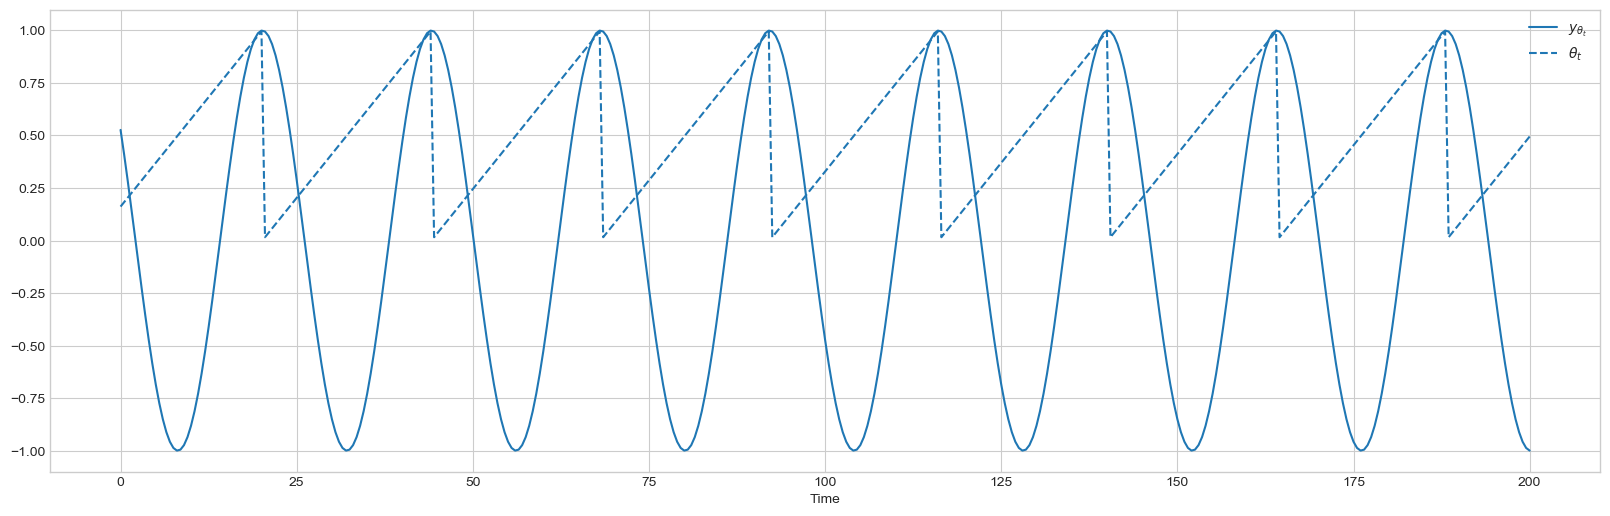

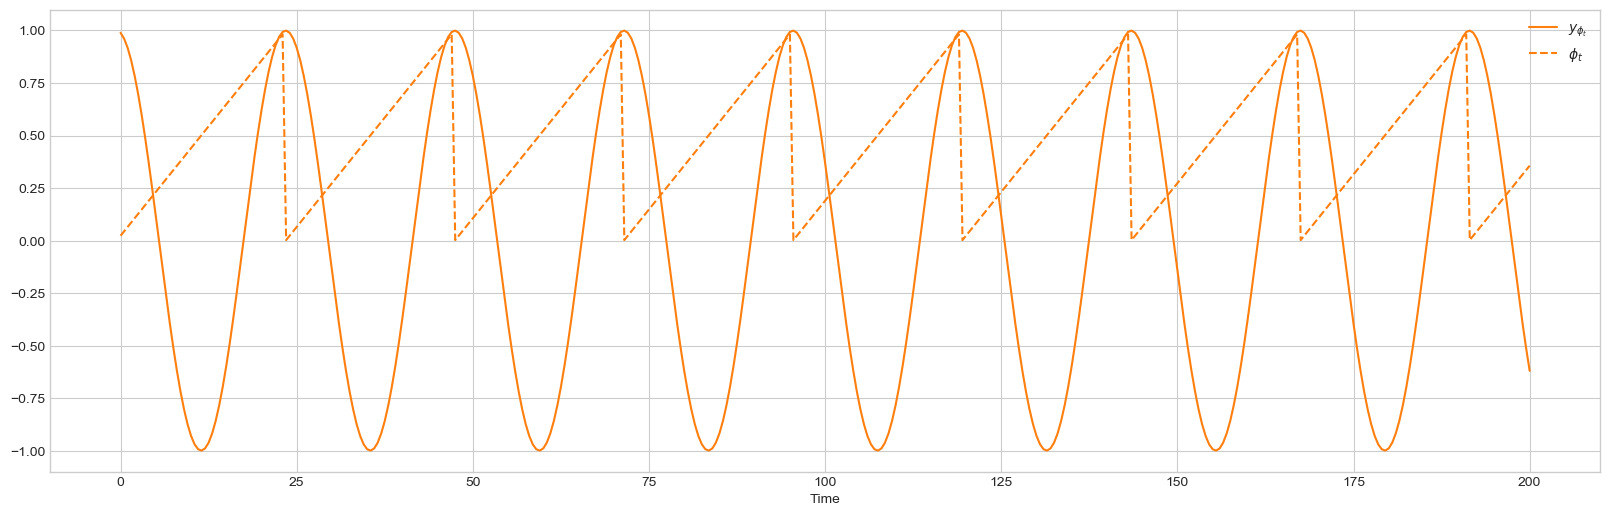

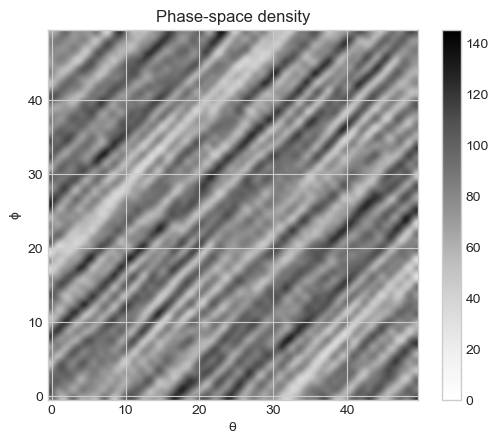

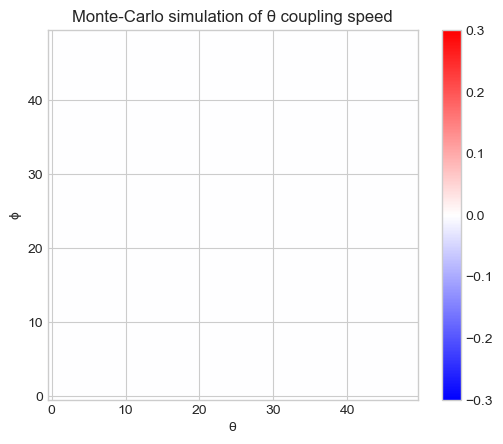

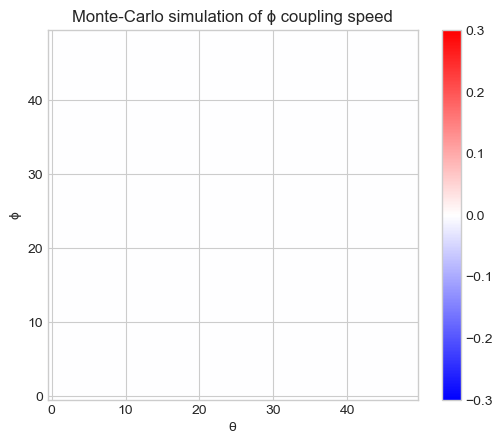

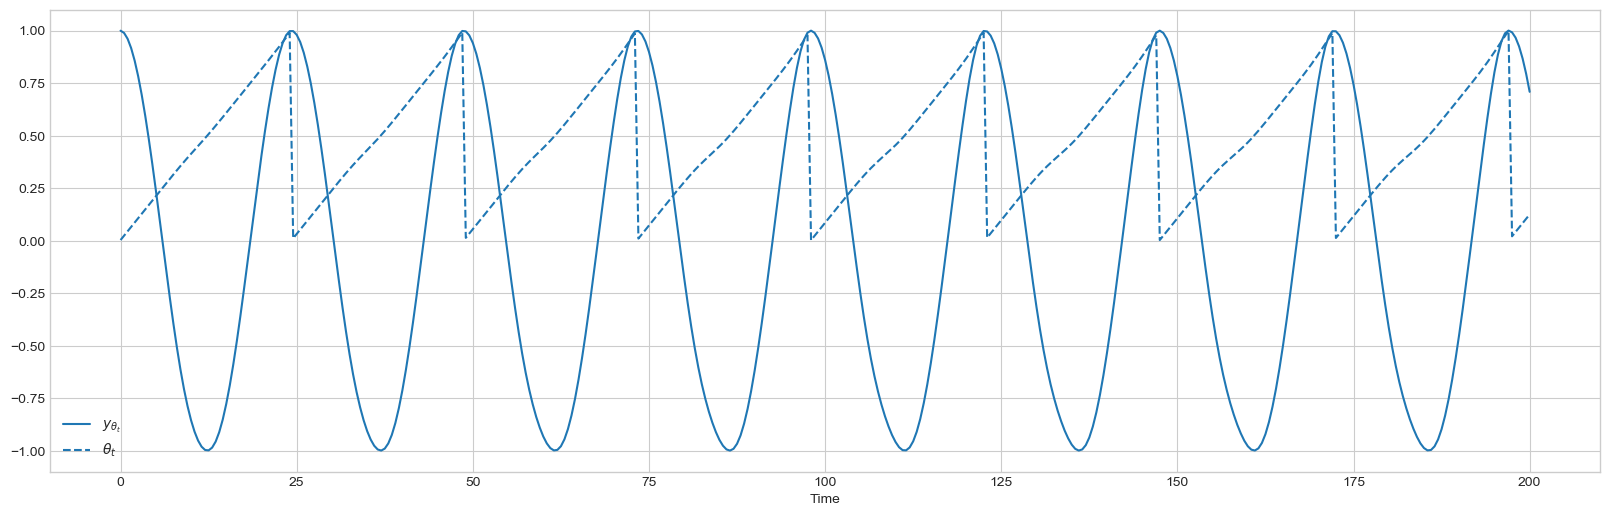

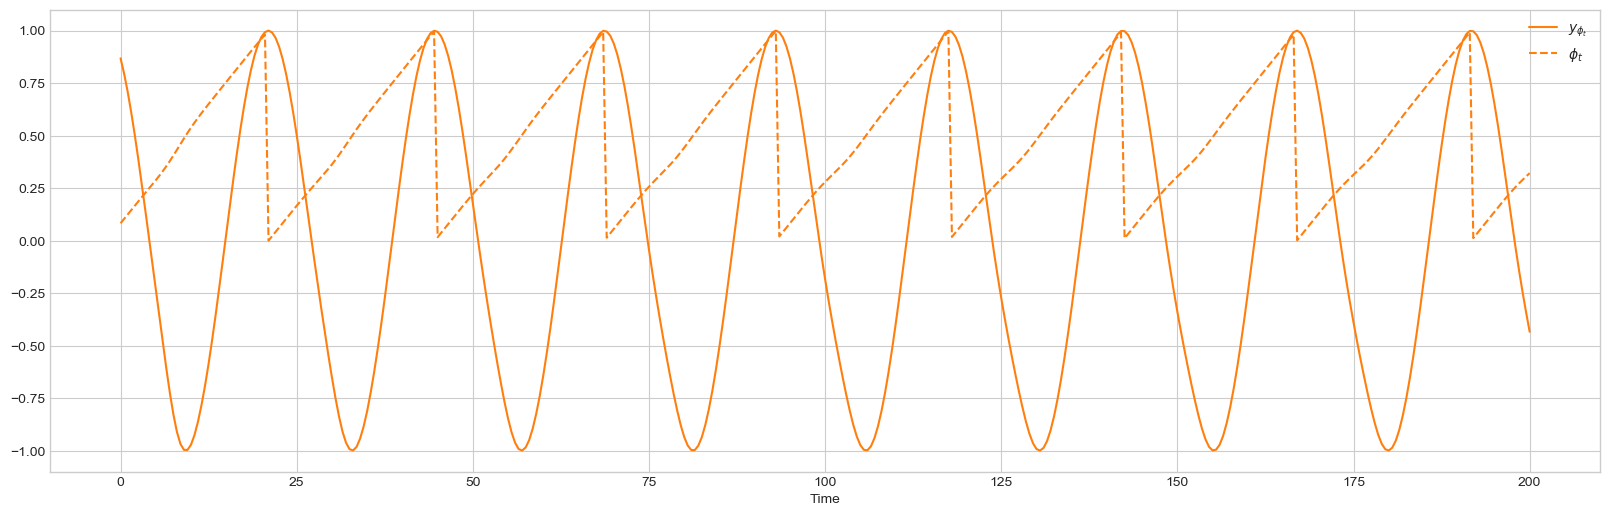

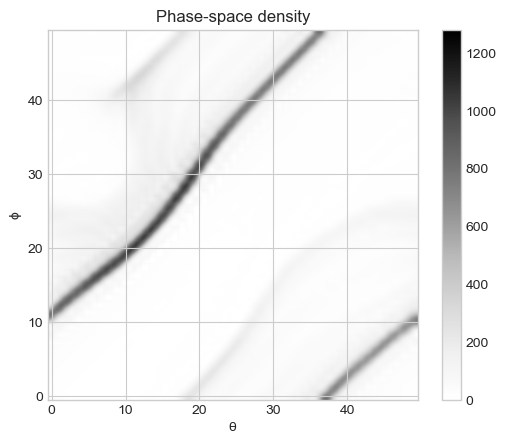

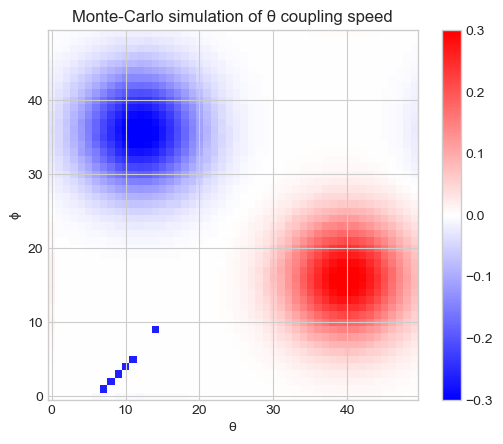

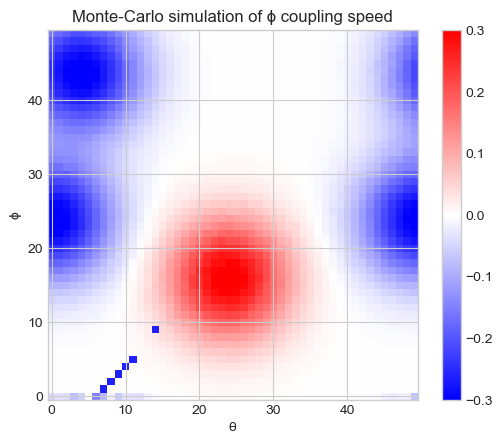

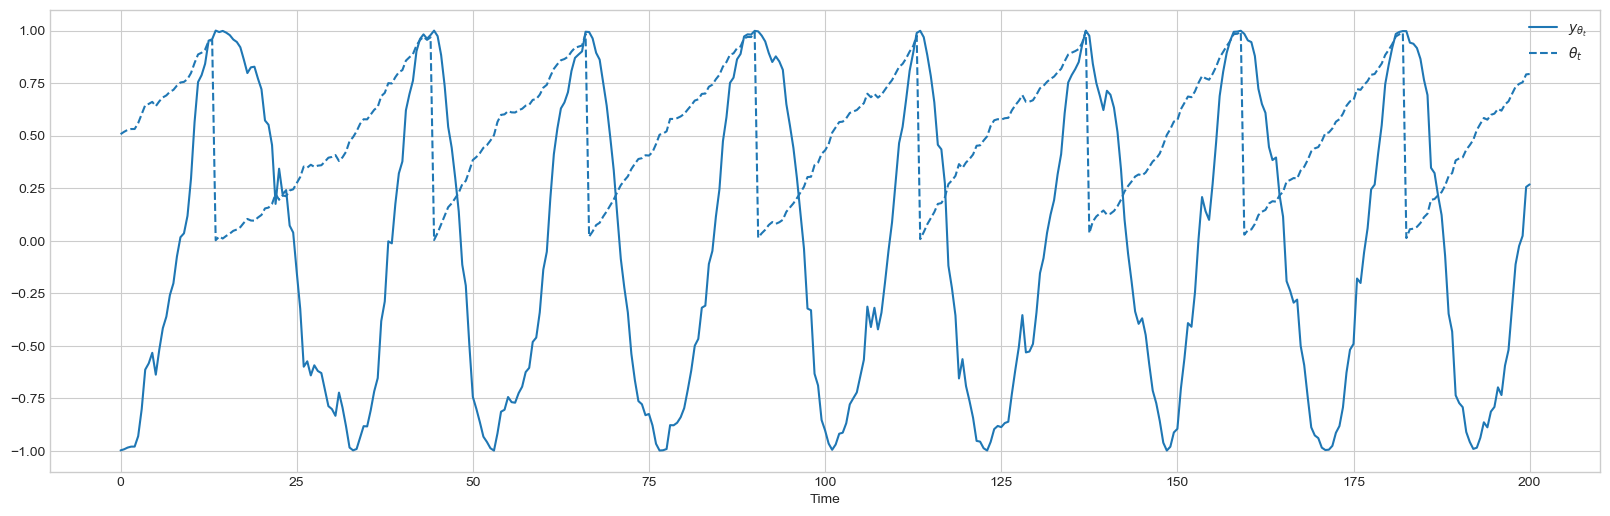

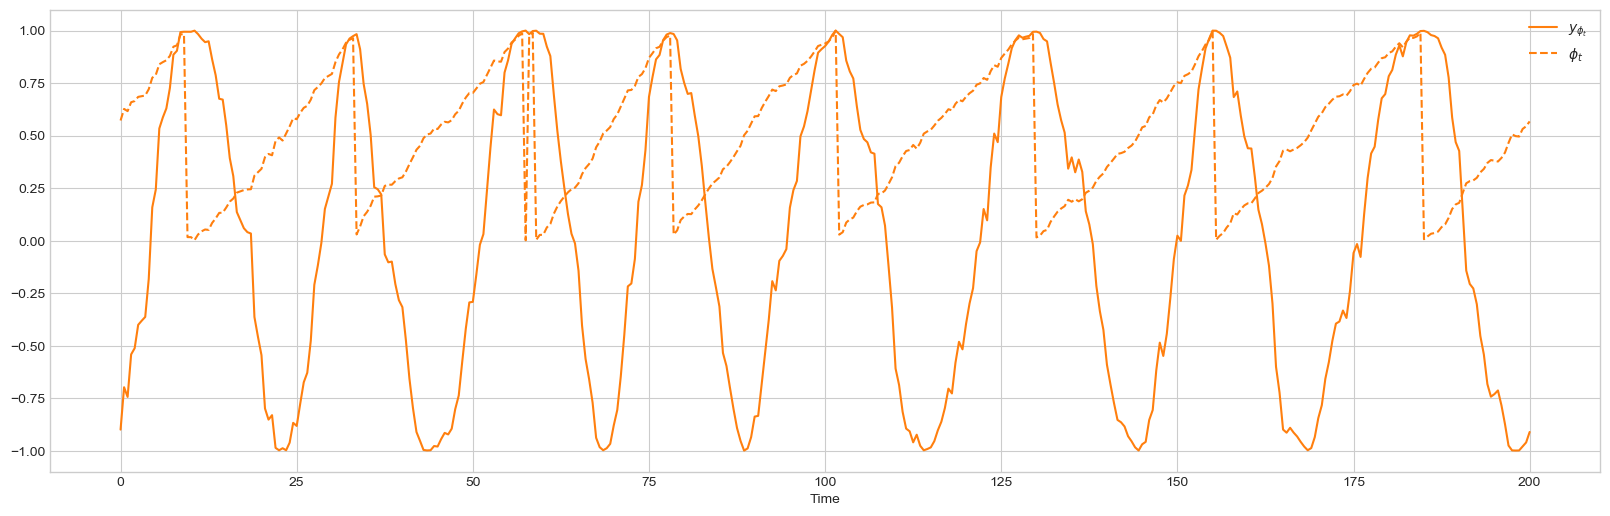

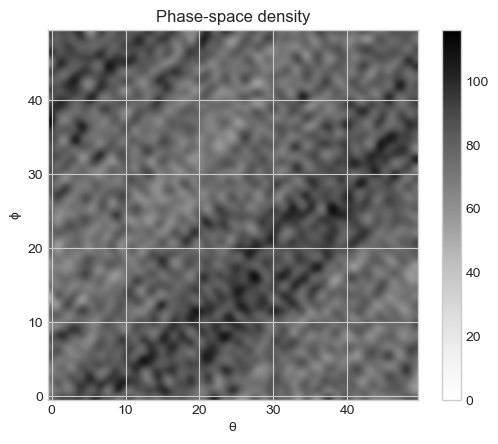

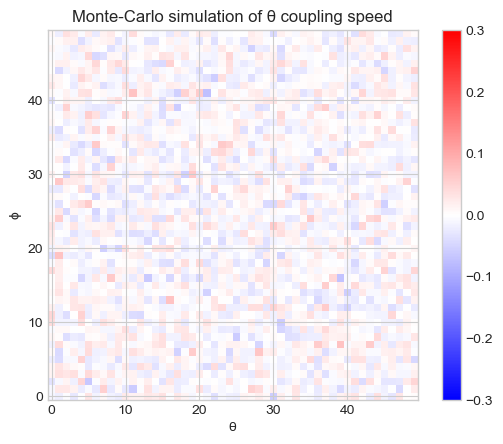

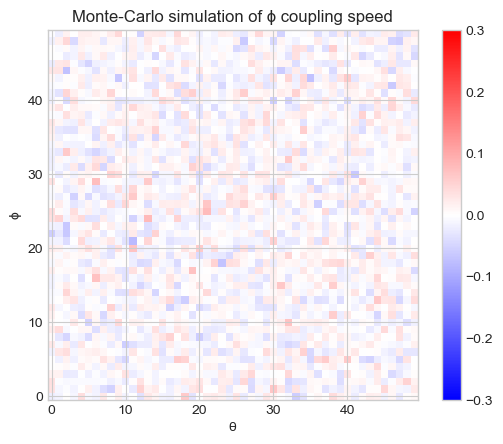

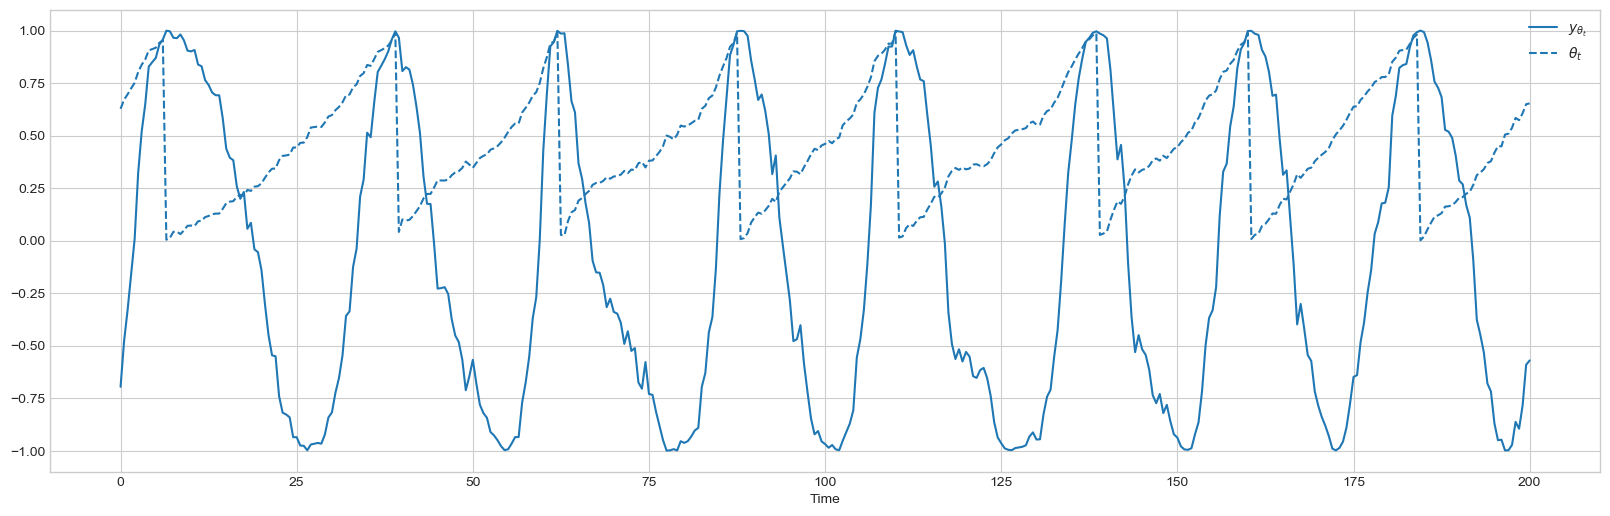

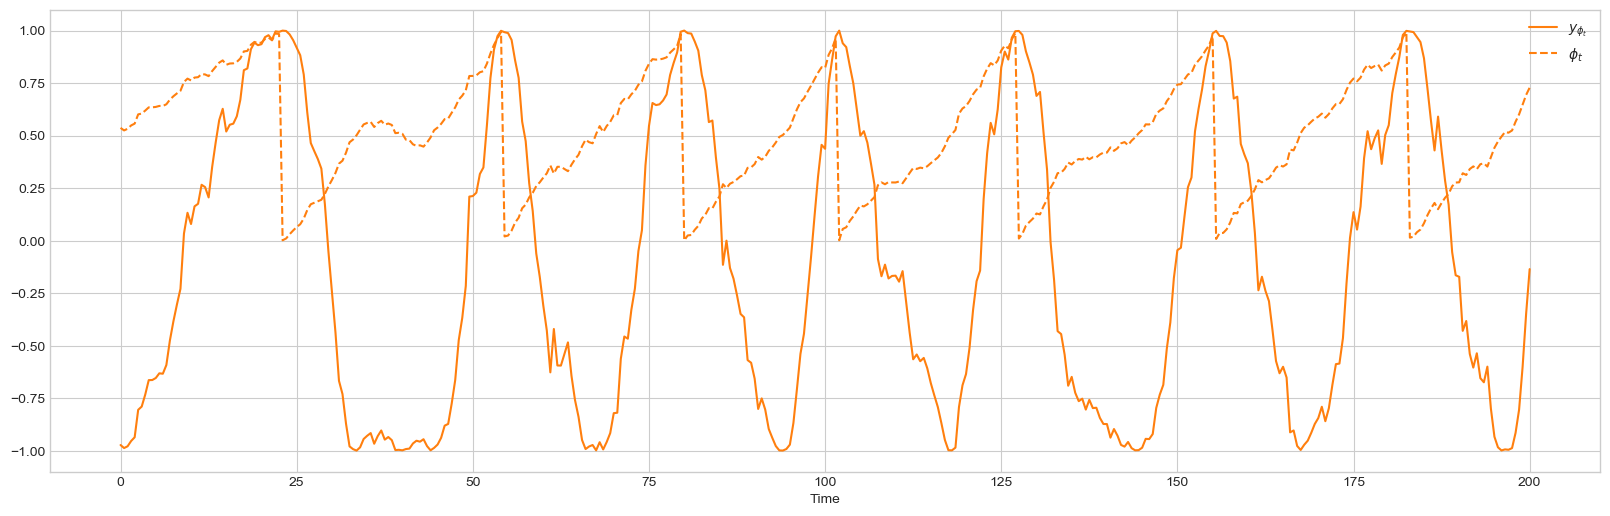

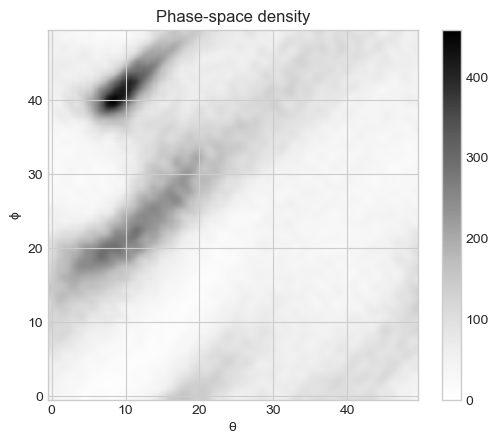

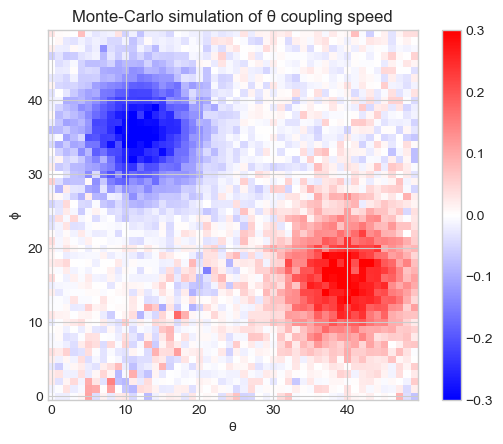

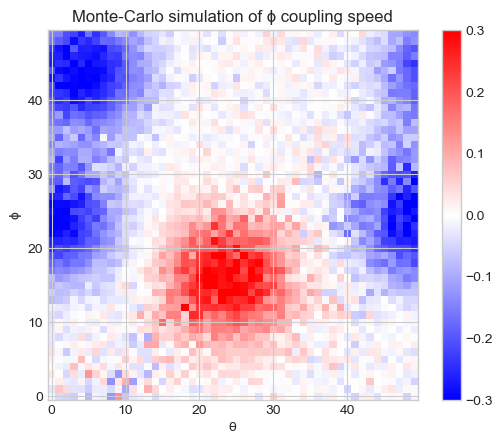

cos_cos_2gaussians_3gaussians_0.2_0.2_0.0_0.0_1.0_0.1_0.0_0.0_0.1_0.0_1.0_0.1_0.0_0.0_0.1_0.0


In [16]:
for ((name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2), (Theta, Phi)) in d_var
    cur_name = name_ω_θ*"_"*name_ω_ϕ*"_"*name_F_θ*"_"*name_F_ϕ*"_"*string(σ_ϕ1)*"_"*string(σ_ϕ2)*"_"*string(σₑ1)*
                       "_"*string(σₑ2)*"_"*string(μₐ1)*"_"*string(γₐ1)*"_"*string(σₐ1)*"_"*string(μᵦ1)*"_"*string(γᵦ1)*
                       "_"*string(σᵦ1)*"_"*string(μₐ2)*"_"*string(γₐ2)*"_"*string(σₐ2)*"_"*string(μᵦ2)*"_"*string(γᵦ2)*
                       "_"*string(σᵦ2)  
    println(cur_name)
        
    path_plots = "Data/"*cur_name*"/Plots/"
    path_traces = "Data/"*cur_name*"/Traces/"
    path_parameters = "Data/"*cur_name*"/Parameters/"
    
    #print all parameters in a file
    writedlm(path_parameters*"original.txt", [name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2])
    
    
    l_traces = []    
    nb_traces = 500
    T = 200
    tspan = 0:0.5:T
    for i in range(1,nb_traces)
        trace = Array{Float64}(undef, 0, 4)
        sim = PhaseSim(Theta,Phi, dt)
        for t in tspan
            it = iterate_process(sim)
            trace = vcat(trace, it)
        end
        push!(l_traces, trace)
        #println(l_traces)
        reset_ϕ(Theta, random = true)
        reset_ϕ(Phi, random = true)
    end


    for trace in l_traces[1:1]
        plot_simulated_trace(trace, tspan, path_plots; split = true)
    end

    #record traces in a file
    for (idx, trace) in enumerate(l_traces)
        writedlm(path_traces*"tr_"*string(idx)*".txt", trace)
    end


    #plot attractor
    res_inf = 50
    F_theta = zeros(res_inf,res_inf)
    F_phi = zeros(res_inf,res_inf)
    F_count = zeros(res_inf,res_inf)
    for idx_trace in 1:size(l_traces,1)
        trace = l_traces[idx_trace]
        v = (trace[2:end,1:2].-trace[1:end-1,1:2])./dt
        for (ph1, ph2,v1,v2) in zip(trace[1:size(v,1),1],trace[1:size(v,1),2],v[:,1],v[:,2])
            ph1_idx::Int64 = round( mod2pi.(ph1)/(2*π)*res_inf)%(res_inf)
            ph2_idx::Int64 = round( mod2pi.(ph2)/(2*π)*res_inf)%(res_inf)
            F_theta[ph1_idx+1, ph2_idx+1] += v1
            F_phi[ph1_idx+1, ph2_idx+1] += v2 
            F_count[ph1_idx+1, ph2_idx+1] += 1
        end
    end

    domain_phase = range(0, stop=2*π, length=res_inf+1)[1:end-1]
    #correct for null count
    for (i_t, theta) in enumerate(domain_phase)
        for (i_p, phi) in enumerate(domain_phase)
            if F_count[i_t, i_p]==0
                F_theta[i_t, i_p] = 0
                F_phi[i_t, i_p] = 0
                F_count[i_t, i_p] = 1
            end
        end
    end
    #average
    F_theta = F_theta./F_count
    F_phi = F_phi./F_count

    #remove natural speed
    F_theta = F_theta.-Theta.f
    F_phi = F_phi.-Phi.f

    #plot
    plot_F(F_count, title_fig = "Phase-space density", vmin = 0, vmax = maximum(F_count), cmap = "Greys", save = true, path = path_plots)
    plot_F(F_theta, title_fig = "Monte-Carlo simulation of θ coupling speed", interpolation = "none", save = true, path = path_plots)
    plot_F(F_phi, title_fig = "Monte-Carlo simulation of ϕ coupling speed",interpolation = "none", save = true, path = path_plots)
end